# XGB Regressor
XGBoost excels at complex, multivariate data with sharp changes, modeling non-linearities for high accuracy, while Prophet shines with clear seasonality/holidays, offering fast, interpretable, univariate forecasts, handling missing data easily, but potentially struggling with very complex patterns. 

In [ ]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")
#print(df_train_clean.head(2))
#print(df_test_clean.head(2))

# create a dataframe to keep track of experiment results. don't intialize if experiment_results already exists
if 'experiment_results' not in globals():
    experiment_results = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation', 'Selected_Columns', 'XGB_Params'])


In [ ]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)



In [30]:
experiment_results.tail()

,R2_Train,R2_Validation,MAPE_Validation,Selected_Columns,XGB_Params
4,0.974560,0.790995,0.228817,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 290, 'learning_rate': 0.2}"
5,0.965163,0.799288,0.223395,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 190, 'learning_rate': 0.2}"
6,0.946277,0.807290,0.217151,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.2}"
7,0.918247,0.807438,0.212519,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.1}"
8,0.890986,0.812093,0.218111,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"


In [ ]:
# Selected variables
# reducing variables to check if it improves model performance
# take only a subset of columns
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'KielerWoche_kiwo', 'school_holiday','public_holiday']
df_train_clean = df_train_clean[selected_columns]
df_validation_clean = df_validation_clean[selected_columns]


In [ ]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday']  # adjust based on your data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean_cat = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False)
df_validation_clean_cat = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)
# align the validation set to have the same columns as the training set
df_validation_clean_cat = df_validation_clean_cat.reindex(columns=df_train_clean_cat.columns, fill_value=0)

# XGBoost

In [ ]:
# xgbost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# prepare features and target (same as before)
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# set hyperparameters
N_ESTIMATORS=90
LEARNING_RATE=0.05


# fit XGBoost
xgb_model = XGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, random_state=42)
xgb_model.fit(X_train, y_train)

# predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_validation_pred = xgb_model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.3f}")
print(f"R2 on validation: {r2_validation:.3f}")
print(f"MAPE on validation: {mape_validation:.3f}")

# for every run push the R2 scores and MAPE with the selected columns list to dataframe to keep record of experiments also add model hyperparameters if needed
experiment_results = pd.concat([experiment_results, pd.DataFrame({
    'R2_Train': [r2_train],
    'R2_Validation': [r2_validation],
    'MAPE_Validation': [mape_validation],
    'Selected_Columns': [selected_columns],
    'XGB_Params': [{'n_estimators': N_ESTIMATORS, 'learning_rate': LEARNING_RATE}]
})], ignore_index=True)


print("Features")
feature_importances = xgb_model.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.3f}")

# optional: plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost Model')
plt.show()


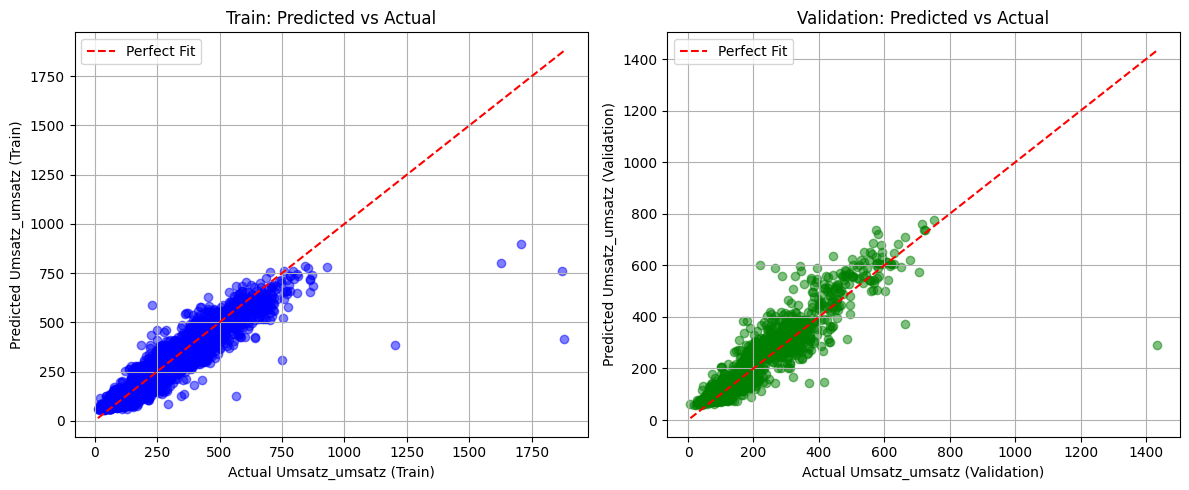

Number of outliers in validation (beyond 3 SD): 23 out of 1841


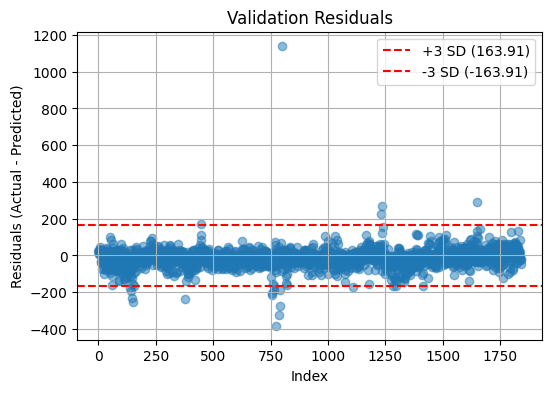

In [27]:
# plot predicted vs actual for train and validation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# calculate residuals for validation
residuals_validation = y_validation - y_validation_pred

# define outliers as residuals beyond 3 standard deviations
threshold = 3 * residuals_validation.std()
outliers_count = (residuals_validation.abs() > threshold).sum()

print(f"Number of outliers in validation (beyond 3 SD): {outliers_count} out of {len(residuals_validation)}")

# optional: plot residuals to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(range(len(residuals_validation)), residuals_validation, alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'+3 SD ({threshold:.2f})')
plt.axhline(y=-threshold, color='r', linestyle='--', label=f'-3 SD ({-threshold:.2f})')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Validation Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.1]
}

# Initialize model with fixed params
xgb_model = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best params and score
print("Best params:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)

# Use best model
best_model = grid_search.best_estimator_

# Evaluate best model on validation set
y_validation_pred_best = best_model.predict(X_validation)
r2_validation_best = r2_score(y_validation, y_validation_pred_best)
mape_validation_best = mean_absolute_percentage_error(y_validation, y_validation_pred_best)

print(f"Best model - R² on validation: {r2_validation_best:.3f}")
print(f"Best model - MAPE on validation: {mape_validation_best:.3f}")
"""


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 1.0}
Best R²: 0.8272306559326006
Best model - R² on validation: 0.812
Best model - MAPE on validation: 0.213


# XGBoost combined

In [ ]:

# merge df_train_clean and df_validation_clean and create df_combined
df_combined = pd.concat([df_train_clean, df_validation_clean], ignore_index=True)
df_combined.head()

In [ ]:
# reducing variables
#selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'school_holiday', 'KielerWoche_kiwo']
# using selected column that we used above
df_combined = df_combined[selected_columns]

In [ ]:
# ...existing code...

categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday'] # adjust based on your data

categorical_cols = [col for col in categorical_cols if col in df_combined.columns]
df_combined = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=False)

# do categorical encoding for test set as well
df_test_clean = pd.get_dummies(df_test_clean, columns=categorical_cols, drop_first=False)

#save id column before reindexing
df_test_id = df_test_clean['id']


df_test_clean = df_test_clean.reindex(columns=df_combined.columns, fill_value=0)
# prepare combined features and target
X_combined = df_combined.drop(columns=[target])
y_combined = df_combined[target]

# fit XGBoost on combined data
xgb_model_combined = XGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, random_state=42)
xgb_model_combined.fit(X_combined, y_combined)

#print feature importances for combined model
print("Features for combined model")
feature_importances_combined = xgb_model_combined.feature_importances_
for feature, importance in zip(X_combined.columns, feature_importances_combined):
    print(f"{feature}: {importance:.3f}")


# only predict on test set
y_test = df_test_clean[target]



X_test = df_test_clean.drop(columns=[target])
y_test_pred = xgb_model_combined.predict(X_test)

# head y_test_pred
print("Test set predictions (first 10):")

print(df_test_clean.head())

# combine df_test_id with y_test_pred into a new dataframe df_xboost_test_predictions
df_xboost_test_predictions = pd.DataFrame({
    'id': df_test_id,
    'umsatz': y_test_pred
})
print(df_xboost_test_predictions.head(10))

# save df_xboost_test_predictions to ../data/processed/xgboost_test_predictions.csv
df_xboost_test_predictions.to_csv("../data/processed/xgboost_test_predictions.csv", index=False)
